***imports***

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split, Subset
from torchvision.datasets import MNIST, FashionMNIST, CIFAR10, EMNIST, USPS,SVHN
from torchvision import transforms
import numpy as np
import random
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.manifold import TSNE
from torch.utils.data import ConcatDataset

***Configuration and Environment Setup***

In [ ]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

epochs = 5
lr = 1e-3
batch_size = 128
embedding_dim = 64
triplet_alpha = 1.0  # Weight for Triplet Loss

num_ood_val = 600
num_ood_test = 600

Using device: cuda


***Datasets Combination***

In [ ]:
class CombineDataset(Dataset):

    def __init__(self, ds_in, ds_ood):
        self.ds_in = ds_in
        self.ds_ood = ds_ood

    def __len__(self):
        return len(self.ds_in) + len(self.ds_ood)

    def __getitem__(self, idx):
        if idx < len(self.ds_in):
            data, label = self.ds_in[idx]
            return data, label
        else:
            data, _ = self.ds_ood[idx - len(self.ds_in)]
            return data, 10

***Evaluation Function***

In [ ]:
def eval_model(model, data_loader, device):

    model.eval()
    correct_mnist = 0
    total_mnist = 0
    correct_ood = 0
    total_ood = 0

    with torch.no_grad():
        for data, labels in data_loader:
            data, labels = data.to(device), labels.to(device)
            outputs = model(data)  # shape (N,11)
            _, y_pred = torch.max(outputs, dim=1)

            mask_in = (labels < 10) # MNIST
            mask_ood = (labels == 10) # OOD

            labels_in = labels[mask_in]
            labels_ood = labels[mask_ood]
            pred_in = y_pred[mask_in]
            pred_ood = y_pred[mask_ood]

            total_mnist += labels_in.size(0)
            correct_mnist += (pred_in == labels_in).sum().item()

            total_ood += labels_ood.size(0)
            correct_ood += (pred_ood == labels_ood).sum().item()

    acc_mnist = correct_mnist / total_mnist if total_mnist>0 else 0 # mnist Accuracy
    acc_ood   = correct_ood / total_ood     if total_ood>0   else 0 # ood Accuracy
    acc_total = (correct_mnist + correct_ood) / (total_mnist + total_ood) # overall Accuracy

    return acc_mnist, acc_ood, acc_total


***Net initialization***

In [ ]:
class CNN_EmbeddingNet_Triplet(nn.Module):
    def __init__(self, embedding_dim=64, dropout_p=0.3):
        super().__init__()
        self.device = device
        # Convs
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2,2)

        # FC
        self.fc1 = nn.Linear(64*7*7, 128)
        self.dropout = nn.Dropout(dropout_p)
        self.fc2 = nn.Linear(128, embedding_dim)

        # Classifier
        self.classifier = nn.Linear(embedding_dim, 10)

    def forward_features(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        emb = self.fc2(x)
        return emb

    def forward_classifier(self, emb):
        return self.classifier(emb)

    def forward_inference_10(self, x):
        emb = self.forward_features(x)
        logits = self.forward_classifier(emb)
        return logits

    def forward(self, x):
        return self.forward_inference_10(x)


***Train***

In [ ]:
def train_one_epoch_triplet(model, loader, optimizer, ce_criterion, triplet_margin=1.0, alpha=1.0):
    model.train()
    triplet_criterion = nn.TripletMarginLoss(margin=triplet_margin, reduction='mean')

    running_loss = 0.0
    running_ce   = 0.0
    running_trip = 0.0
    total_samples = 0
    correct = 0

    for data, labels in loader:
        data, labels = data.to(device), labels.to(device)
        optimizer.zero_grad()

        logits = model.forward_inference_10(data)
        ce_loss = ce_criterion(logits, labels)

        preds = torch.argmax(logits, dim=1)
        correct += (preds == labels).sum().item()
        total_samples += labels.size(0)

        emb = model.forward_features(data)

        anchor_list = []
        pos_list = []
        neg_list = []

        label2indices = {}
        for i, lab in enumerate(labels):
            lab_i = lab.item()
            label2indices.setdefault(lab_i, []).append(i)

        for i, lab in enumerate(labels):
            anchor_label = lab.item()
            if len(label2indices[anchor_label]) < 2:
                continue
            pos_idx = i
            while pos_idx == i:
                pos_idx = random.choice(label2indices[anchor_label])

            neg_label = anchor_label
            while neg_label == anchor_label:
                neg_label = random.choice(list(label2indices.keys()))
            neg_idx = random.choice(label2indices[neg_label])

            anchor_list.append(emb[i].unsqueeze(0))
            pos_list.append(emb[pos_idx].unsqueeze(0))
            neg_list.append(emb[neg_idx].unsqueeze(0))

        if len(anchor_list) > 0:
            anchor_t = torch.cat(anchor_list, dim=0)
            pos_t = torch.cat(pos_list, dim=0)
            neg_t = torch.cat(neg_list, dim=0)
            trip_loss = triplet_criterion(anchor_t, pos_t, neg_t)
        else:
            trip_loss = torch.tensor(0.0, device=device)

        total_loss = ce_loss + alpha*trip_loss
        total_loss.backward()
        optimizer.step()

        running_loss += total_loss.item() * data.size(0)
        running_ce   += ce_loss.item() * data.size(0)
        running_trip += trip_loss.item() * data.size(0)

    ep_loss = running_loss / total_samples
    ep_ce   = running_ce / total_samples
    ep_trip = running_trip / total_samples
    ep_acc  = correct / total_samples

    return ep_loss, ep_ce, ep_trip, ep_acc

***Classifier Evaluation***

In [ ]:
def evaluate_classifier(model, loader, ce_criterion):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for data, labels in loader:
            data, labels = data.to(device), labels.to(device)
            logits = model.forward_inference_10(data)
            ce_loss = ce_criterion(logits, labels)

            total_loss += ce_loss.item() * data.size(0)
            preds = torch.argmax(logits, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return total_loss/total, correct/total

***Clustering***

In [ ]:
def compute_dbscan_clusters(model, dataset, eps, min_samples):
    """
    For each class c in 0..9, gather embeddings and run DBSCAN with (eps,min_samples).
    Return a dict c -> list of (centroid, radius) for each cluster.
    """

    model.eval()
    label2vecs = {c: [] for c in range(10)}

    loader = DataLoader(dataset, batch_size=256, shuffle=False)
    with torch.no_grad():
        for data, labels in loader:
            data, labels = data.to(device), labels.to(device)
            emb = model.forward_features(data)
            emb_np = emb.cpu().numpy()  # shape (B,embedding_dim)
            for i, lab in enumerate(labels):
                label2vecs[lab.item()].append(emb_np[i])

    dbscan_dict = {}
    for c in range(10):
        arr = np.vstack(label2vecs[c])  # (samples_in_class,embedding_dim)
        if len(arr) == 0:
            dbscan_dict[c] = []
            continue

        dbs = DBSCAN(eps=eps, min_samples=min_samples)
        cluster_labels = dbs.fit_predict(arr)

        clusters_info = []
        unique_labels = set(cluster_labels) - {-1}
        for clab in unique_labels:
            points_in_cluster = arr[cluster_labels == clab]
            centroid = points_in_cluster.mean(axis=0)
            dists = np.sqrt(((points_in_cluster - centroid)**2).sum(axis=1))
            radius = dists.max()
            clusters_info.append({
                "centroid": centroid,
                "radius": radius
            })
        dbscan_dict[c] = clusters_info

    return dbscan_dict


***Wrapping***

In [ ]:
class OSRWrapperDBSCAN(nn.Module):
    def __init__(self, core_model, dbscan_dict, prob_threshold=0.8, dist_factor=1.0):
        """
        1) If maxProb < prob_threshold => unknown
        2) Else find nearest cluster (by centroid) in predicted class -> check distance < radius*dist_factor
        """
        super().__init__()
        self.core_model = core_model
        self.dbscan_dict = dbscan_dict
        self.prob_threshold = prob_threshold
        self.dist_factor = dist_factor

    def forward(self, x):
        emb = self.core_model.forward_features(x)
        logits_10 = self.core_model.forward_classifier(emb)
        probs_10 = F.softmax(logits_10, dim=1)

        out_11 = torch.zeros(x.size(0), 11, device=x.device)
        out_11[:, :10] = logits_10

        max_probs, pred_c = torch.max(probs_10, dim=1)
        emb_np = emb.detach().cpu().numpy()

        for i in range(x.size(0)):
            p = max_probs[i].item()
            c = pred_c[i].item()

            if p < self.prob_threshold:
                out_11[i, c] = -10.0
                out_11[i, 10] = 10.0
                continue

            clusters_info = self.dbscan_dict[c]
            if len(clusters_info) == 0:
                out_11[i, c] = -10.0
                out_11[i, 10] = 10.0
                continue

            sample_emb = emb_np[i]
            min_dist = 1e9
            best_rad = 0.0
            for info in clusters_info:
                centroid = info["centroid"]
                radius = info["radius"]
                dist = np.sqrt(((sample_emb - centroid)**2).sum())
                if dist < min_dist:
                    min_dist = dist
                    best_rad = radius

            if min_dist > best_rad*self.dist_factor:
                out_11[i, c] = -10.0
                out_11[i, 10] = 10.0
            else:
                out_11[i, 10] = -10.0

        return out_11

***MNIST: In-Distribution Dataset***

In [ ]:
# Transforms for MNIST
transform_mnist_train = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.RandomRotation(15),
    transforms.RandomAffine(0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

transform_mnist_test = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Load MNIST dataset
mnist_train_full = MNIST(root='./data', train=True, download=True, transform=transform_mnist_train)
mnist_test = MNIST(root='./data', train=False, download=True, transform=transform_mnist_test)

# Split MNIST training set into train and validation
val_ratio = 0.1
train_size = int((1 - val_ratio) * len(mnist_train_full))
val_size = len(mnist_train_full) - train_size

mnist_train_ds, mnist_val_ds = torch.utils.data.random_split(
    mnist_train_full, [train_size, val_size], generator=torch.Generator().manual_seed(SEED))

# Override transform for validation set
mnist_val_ds.dataset.transform = transform_mnist_test

# Create DataLoaders
train_loader = DataLoader(mnist_train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(mnist_val_ds, batch_size=batch_size, shuffle=False)
mnist_test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=False)

print("MNIST datasets loaded.")

MNIST datasets loaded.


***Load ood_dataset and combine***

In [ ]:
def load_ood_dataset(ood_test):
  # Randomly select OOD samples from the chosen dataset
  inds = list(range(len(ood_test)))
  random.shuffle(inds)

  inds_ood_val = inds[:num_ood_val]
  inds_ood_test = inds[num_ood_val: num_ood_val + num_ood_test]

  ood_val_ds = Subset(ood_test, inds_ood_val)
  ood_test_ds = Subset(ood_test, inds_ood_test)

  val_ood_ds = CombineDataset(mnist_val_ds, ood_val_ds)
  test_ood_ds = CombineDataset(mnist_test, ood_test_ds)

  val_ood_loader = DataLoader(val_ood_ds, batch_size=256, shuffle=False)
  test_ood_loader = DataLoader(test_ood_ds, batch_size=256, shuffle=False)

  return val_ood_loader, test_ood_loader

***Load ood_dataSet***

In [ ]:
# Common transformation for CIFAR10, EMNIST, FashionMNIST, and OtherDataset
transform_ood = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.Grayscale(num_output_channels=1),  # Convert RGB to grayscale
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Select which ood to test on
# ======================================================================

# Load CIFAR10 as OOD dataset
# cifar_test = CIFAR10(root='./data', train=False, download=True, transform=transform_ood)
# ood_test = cifar_test
# ood_title = "cifar10"

# Load EMNIST as OOD dataset
# emnist_test = EMNIST(root='./data', split="letters", train=False, download=True, transform=transform_ood)
# ood_test = emnist_test
# ood_title = "emnist"

# Load fashionMNIST as OOD dataset
fashion_mnist_test = FashionMNIST(root='./data', train=False, download=True, transform=transform_ood)
ood_test = fashion_mnist_test
ood_title = "fashionMNIST"

# Load USPS as OOD dataset
# usps_test = USPS(root='./data', train=False, download=True, transform=transform_ood)
# ood_test = usps_test
# ood_title = "usps"

# Load SVHN as OOD dataset
# svhn_test = SVHN(root='./data', download=True, transform=transform_ood)
# ood_test = svhn_test
# ood_title = "SVHN"

# ======================================================================
# Load YOUR_DATASET as OOD dataset
# your_dataset_test = YOUR_DATASET(root='./data', train=False, download=True, transform=transform_ood)  # Replace this with your actual dataset
# ood_test = your_dataset_test
# ood_title = "YOUR_DATASET"
# ======================================================================

val_ood_loader, test_ood_loader = load_ood_dataset(ood_test)
print(f"Loaded {ood_title} as OOD dataset.")


Loaded fashionMNIST as OOD dataset.


***Plot Training and Validation Losses***

In [ ]:
def plot_trainingAndValidationLoss(train_losses, val_losses):
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
    plt.plot(range(1, epochs+1), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

In [ ]:
#eval_mode = False
eval_mode = True

***Train and Evaluate stage***

=== Training CNN Embedding Model (Triplet+CE) on MNIST ===
Epoch 1/5 | TrainLoss=0.4845 (CE=0.3095, T=0.1750), Acc=0.9074 | ValLoss=0.0683, ValAcc=0.9795
Epoch 2/5 | TrainLoss=0.1396 (CE=0.0813, T=0.0583), Acc=0.9762 | ValLoss=0.0513, ValAcc=0.9842
Epoch 3/5 | TrainLoss=0.1019 (CE=0.0579, T=0.0440), Acc=0.9824 | ValLoss=0.0454, ValAcc=0.9868
Epoch 4/5 | TrainLoss=0.0841 (CE=0.0487, T=0.0354), Acc=0.9858 | ValLoss=0.0414, ValAcc=0.9878
Epoch 5/5 | TrainLoss=0.0703 (CE=0.0395, T=0.0308), Acc=0.9883 | ValLoss=0.0399, ValAcc=0.9887
Saved weights to mnist_cnn_triplet_dbscan_tuning.pth


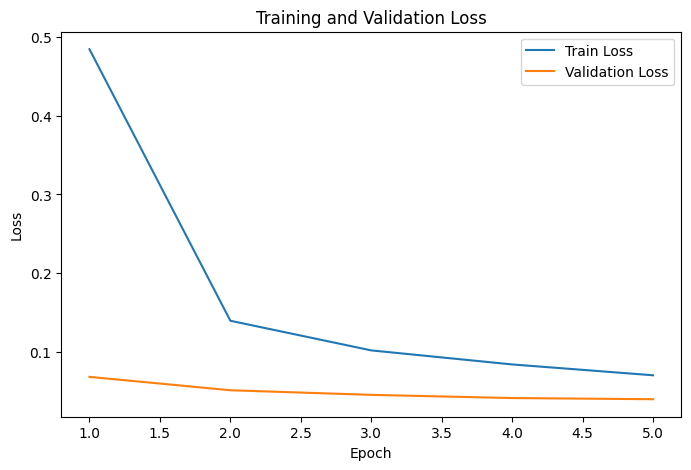

In [ ]:
core_model = CNN_EmbeddingNet_Triplet(embedding_dim=embedding_dim, dropout_p=0.35).to(device)
optimizer = optim.Adam(core_model.parameters(), lr=lr)
ce_criterion = nn.CrossEntropyLoss()

# Lists to store training and validation losses for plotting
train_losses = []
val_losses = []

if not eval_mode:
    print("=== Training CNN Embedding Model (Triplet+CE) on MNIST ===")
    for ep in range(1, epochs+1):
        total_loss, ce_val, trip_val, train_acc = train_one_epoch_triplet(
            core_model, train_loader, optimizer, ce_criterion,
            triplet_margin=1.0, alpha=triplet_alpha
        )
        val_loss, val_acc = evaluate_classifier(core_model, val_loader, ce_criterion)

        train_losses.append(total_loss)
        val_losses.append(val_loss)

        print(f"Epoch {ep}/{epochs} | "
              f"TrainLoss={total_loss:.4f} (CE={ce_val:.4f}, T={trip_val:.4f}), "
              f"Acc={train_acc:.4f} | ValLoss={val_loss:.4f}, ValAcc={val_acc:.4f}")

    torch.save(core_model.state_dict(), "mnist_cnn_triplet_dbscan_tuning.pth")
    print("Saved weights to mnist_cnn_triplet_dbscan_tuning.pth")

    plot_trainingAndValidationLoss(train_losses, val_losses)
else:
    core_model.load_state_dict(torch.load("mnist_cnn_triplet_dbscan_tuning.pth", map_location=device))
    print("Loaded weights from mnist_cnn_triplet_dbscan_tuning.pth")



***Hyperparameter Tuning***

In [ ]:
if eval_mode:
    eps_best=2.2
    min_s_best=7
    prob_best=0.6
    dist_f_best=1
    core_model.load_state_dict(torch.load("mnist_cnn_triplet_dbscan_tuning.pth", map_location=device))
    print("Loaded weights from mnist_cnn_triplet_dbscan_tuning.pth")

else:
    eps_grid = [1.6, 1.8, 2.0, 2.2]
    min_samples_grid = [5, 7, 9]
    prob_grid = [0.6, 0.8]
    dist_factor_grid = [1.0, 1.2]

    best_config = None
    best_total = 0.0
    best_ood = 0.0
    print("\n=== Hyperparameter Tuning over DBSCAN + prob_threshold + dist_factor ===")
    for eps_val in eps_grid:
        for min_s in min_samples_grid:
            # compute DBSCAN clusters for current combination
            dbscan_dict = compute_dbscan_clusters(core_model, mnist_train_ds, eps=eps_val, min_samples=min_s)
            for prob_t in prob_grid:
                for dist_f in dist_factor_grid:
                    # build a wrapper model
                    temp_model = OSRWrapperDBSCAN(
                        core_model,
                        dbscan_dict,
                        prob_threshold=prob_t,
                        dist_factor=dist_f
                    ).to(device)

                    acc_mnist, acc_ood, acc_total = eval_model(temp_model, val_ood_loader, device)

                    if (acc_total > best_total) and (acc_ood*100 > 80) and (acc_total - best_total > best_ood - acc_ood):
                        best_total = acc_total
                        best_ood = acc_ood
                        best_config = (eps_val, min_s, prob_t, dist_f)
                        print(f"New best: eps={eps_val}, minS={min_s}, prob={prob_t}, distF={dist_f}, acc_ood={acc_ood*100:.2f}% ,acc_total={acc_total*100:.2f}%")

    eps_best, min_s_best, prob_best, dist_f_best = best_config
    print(f"\nBest config = eps={eps_best}, min_samples={min_s_best}, prob={prob_best}, dist_factor={dist_f_best}, acc_ood={best_ood*100:.2f}% , acc_total={best_total*100:.2f}%")



=== Hyperparameter Tuning over DBSCAN + prob_threshold + dist_factor ===
New best: eps=1.6, minS=5, prob=0.6, distF=1.0, acc_ood=99.67% ,acc_total=76.70%
New best: eps=1.6, minS=5, prob=0.6, distF=1.2, acc_ood=99.17% ,acc_total=78.12%
New best: eps=1.6, minS=7, prob=0.6, distF=1.0, acc_ood=99.83% ,acc_total=78.76%
New best: eps=1.6, minS=7, prob=0.6, distF=1.2, acc_ood=99.67% ,acc_total=81.88%
New best: eps=1.6, minS=9, prob=0.6, distF=1.0, acc_ood=99.67% ,acc_total=84.98%
New best: eps=1.6, minS=9, prob=0.6, distF=1.2, acc_ood=98.50% ,acc_total=90.06%
New best: eps=1.8, minS=9, prob=0.6, distF=1.0, acc_ood=99.00% ,acc_total=90.62%
New best: eps=2.0, minS=5, prob=0.6, distF=1.0, acc_ood=98.83% ,acc_total=91.38%
New best: eps=2.0, minS=7, prob=0.6, distF=1.0, acc_ood=98.50% ,acc_total=92.36%
New best: eps=2.2, minS=9, prob=0.6, distF=1.0, acc_ood=96.33% ,acc_total=95.58%

Best config = eps=2.2, min_samples=9, prob=0.6, dist_factor=1.0, acc_ood=96.33% , acc_total=95.58%


***Final Evaluation***

In [ ]:
#  compute DBSCAN again with best config, and evaluate on test set
dbscan_dict_final = compute_dbscan_clusters(core_model, mnist_train_ds, eps=eps_best, min_samples=min_s_best)
final_model = OSRWrapperDBSCAN(core_model, dbscan_dict_final, prob_threshold=prob_best, dist_factor=dist_f_best).to(device)

acc_mnist_test, acc_ood_test, acc_total_test = eval_model(final_model, test_ood_loader, device)
print("\n=== Final OSR (with best config) on Test ===")
print(f"Accuracy on MNIST: {acc_mnist_test*100:.2f}%")
print(f"Accuracy on OOD ({ood_title}):   {acc_ood_test*100:.2f}%")
print(f"Total Accuracy:    {acc_total_test*100:.2f}%")

print("Done.")



=== Final OSR (with best config) on Test ===
Accuracy on MNIST: 95.69%
Accuracy on OOD (fashionMNIST):   96.33%
Total Accuracy:    95.73%
Done.


***Confusion Matrix for 11 classes (0-9 + Unknown)***

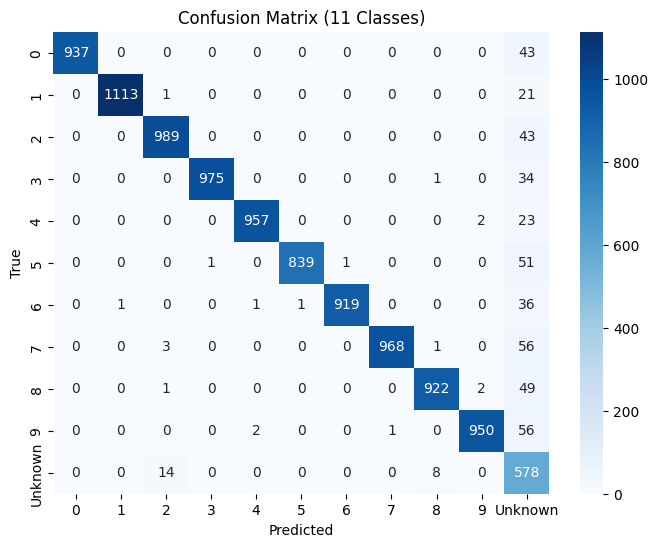

In [ ]:
final_model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for data, labels in test_ood_loader:
        data, labels = data.to(device), labels.to(device)
        outputs = final_model(data)
        _, preds = torch.max(outputs, dim=1)
        all_preds.append(preds.cpu().numpy())
        all_labels.append(labels.cpu().numpy())
all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

cm_11 = confusion_matrix(all_labels, all_preds, labels=list(range(10)) + [10])
plt.figure(figsize=(8, 6))
sns.heatmap(cm_11, annot=True, fmt='d', cmap='Blues',
            xticklabels=list(range(10)) + ['Unknown'],
            yticklabels=list(range(10)) + ['Unknown'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (11 Classes)')
plt.show()

***Binary Confusion Matrix (Known vs Unknown)***

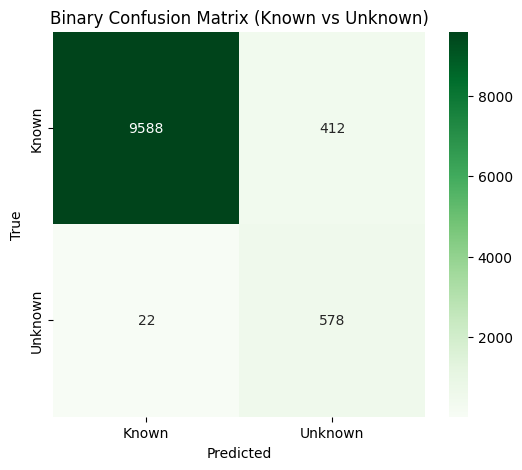

In [ ]:
binary_preds = np.where(all_preds < 10, 0, 1)
binary_labels = np.where(all_labels < 10, 0, 1)
cm_bin = confusion_matrix(binary_labels, binary_preds, labels=[0, 1])
plt.figure(figsize=(6, 5))
sns.heatmap(cm_bin, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Known', 'Unknown'],
            yticklabels=['Known', 'Unknown'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Binary Confusion Matrix (Known vs Unknown)')
plt.show()

***t-SNE Visualization of Embeddings from Test Set***

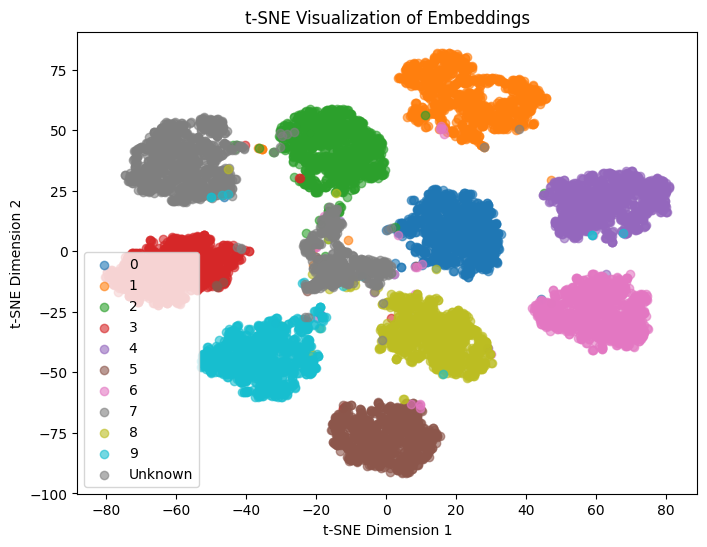

In [ ]:
all_embeddings = []
all_labels_emb = []
with torch.no_grad():
    for data, labels in test_ood_loader:
        data, labels = data.to(device), labels.to(device)
        emb = final_model.core_model.forward_features(data)
        all_embeddings.append(emb.cpu().numpy())
        all_labels_emb.append(labels.cpu().numpy())
all_embeddings = np.concatenate(all_embeddings)
all_labels_emb = np.concatenate(all_labels_emb)

tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(all_embeddings)

plt.figure(figsize=(8, 6))
colors = plt.cm.tab10(np.linspace(0, 1, 10))
colors = np.vstack([colors, np.array([0.5, 0.5, 0.5, 1])])  # Color for Unknown
for label in np.unique(all_labels_emb):
    idx = all_labels_emb == label
    plt.scatter(embeddings_2d[idx, 0], embeddings_2d[idx, 1],
                color=colors[label] if label < 10 else colors[-1],
                label=str(label) if label < 10 else 'Unknown',
                alpha=0.6)
plt.legend()
plt.title('t-SNE Visualization of Embeddings')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()